In [1]:
import os
import csv
import librosa
import numpy as np
import torch
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from pandas import read_csv
from torch.utils.data import random_split, DataLoader, Dataset
# matplotlib.use('Qt5Agg')

#### Read metadata file

In [2]:
directory = Path.cwd()
csvfile   = read_csv(directory/'Data'/'metadata.csv')

#### Functions to plot the audio signal, fft and spectrogram

In [3]:
def get_file_details(_id):
    
    ''' Function to get details of the given audio signal '''
    
    # Input: 
    # _id: ID of the audio signal from the metadata csv file
    
    # Output:
    # _audio_file: Path to the given audio signal
    # _sample_rate: Sampling rate of the audio signal
    
    _audio_file  = directory / 'Data' / csvfile['label'][_id] / csvfile['file'][_id]
    _sample_rate = csvfile['sampleRate'][_id]
    
    return _audio_file, _sample_rate
    
def plot_signal(_id):
    
    ''' Function to plot the audio signal vs time '''
    
    # Input: 
    # _id: ID of the audio signal from the metadata csv file
    
    # Output:
    # y: Amplitude of the signal at different time-steps
    
    _audio_file, _sample_rate = get_file_details(_id)
    y            = librosa.load(_audio_file, sr = _sample_rate)
    librosa.display.waveshow(y[0], sr = y[1])
    plt.title('Audio Signal: ' + csvfile['file'][_id] + ' from class: ' + csvfile['label'][_id])
    plt.savefig(str(_id) + '.jpg')
    
    return y

def plot_signal_fft(_id):
    
    ''' Function to plot the FFT of the given audio signal '''
    
    # Input: 
    # _id: ID of the audio signal from the metadata csv file
    
    # Output:
    # fft: FFT Spectrum of the given audio signal
    
    y        = plot_signal(_id)
    
    # Perform Fourier Transform
    fft      = np.fft.fft(y[0])

    # Take abs values to get magnitude
    spectrum = np.abs(fft)

    # Create frequency vector
    f           = np.linspace(0, y[1], len(spectrum))

    # One half of the spectrum and frequency
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f        = f[:int(len(spectrum)/2)]

    # Plot spectrum
    plt.figure()
    plt.plot(left_f, left_spectrum)
    plt.xlabel("Frequency (in Hz)")
    plt.ylabel("Magnitude")
    plt.title('FFT Power Spectrum: ' + csvfile['file'][_id] + ' from class: ' + csvfile['label'][_id])
    plt.savefig('FFT_' + str(_id) + '.jpg')
    plt.show()
    
    return fft

def plot_signal_spectrogram(_id):
    
    ''' Function to plot the Mel-Spectrogram of the given audio signal '''
    
    # Input: 
    # _id: ID of the audio signal from the metadata csv file
    
    _audio_file, _sample_rate = get_file_details(_id)
    y            = librosa.load(_audio_file, sr = _sample_rate)
    stft         = np.abs(librosa.stft(y[0], center = False))
    fig, ax      = plt.subplots()
    img          = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), n_fft=1024, y_axis='time', x_axis='mel', sr = _sample_rate, ax=ax)
    ax.set_title('Spectrogram: ' + csvfile['file'][_id] + ' from class: ' + csvfile['label'][_id])
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.savefig('Spectrogram' + str(_id) + '.jpg')
    plt.show()

#### Functions to pre-process the signal

In [4]:
def open_file(_id):
    
    ''' Function to open the audio signal using torchaudio '''
    
    # Input: 
    # _id: ID of the audio signal from the metadata csv file
    
    # Output:
    # _audio_signal: tensor of the corresponding audio signal opened using torchaudio
    # _sample_rate: Sampling rate of the audio signal
    
    _audio_file, _sample_rate = get_file_details(_id)
    _audio_signal, _          = torchaudio.load(_audio_file)
    
    return _audio_signal, _sample_rate

def reform_channel(_audio_signal):
    
    ''' Function to reform the audio signal into 2 channels '''
    
    # Input: 
    # _audio_signal: tensor of the audio signal
    
    # Output:
    # _reformed_signal: tensor of the audio signal reformed into 2 channels
    
    
    # Return the original signal if the audio signal originally has 2 channels
    if _audio_signal.shape[0] == 2:
        return _audio_signal
    
    # If the audio signal has 1 channel, reform it to 2 channels
    elif _audio_signal.shape[0] == 1:
        _reformed_signal = torch.cat([_audio_signal, _audio_signal])
    
    return _reformed_signal

def reform_sampling(_audio_signal, _old_sr, _new_sr):
    
    ''' Function to standardize the sampling rate of the audio signal '''
    
    # Input: 
    # _audio_signal: tensor of the audio signal
    # _old_sr: Original sampling rate of the audio signal
    # _new_sr: New sampling rate to which the signal should be reformed
    
    # Output:
    # _reformed_signal: tensor of the audio signal reformed as per new sampling rate
    
    # Check if the sampling rate of audio signal is same as new sampling rate
    if _old_sr == _new_sr:
        return _audio_signal
    
    # Reform the signal as per new sampling rate if it is different from original sampling rate
    _new_size        = np.ceil((_audio_signal.shape[1] * _new_sr) / _old_sr).astype(int)
    _reformed_signal = torch.zeros((2, _new_size))
    
    for i in range(_audio_signal.shape[0]):
        _reformed_signal[i, :] = torchaudio.transforms.Resample(_old_sr, _new_sr)(_audio_signal[i, :])
    
    return _reformed_signal

def resize_signal(_audio_signal):
    
    ''' Function to standardize the audio signal size to 4s '''
    
    # Input: 
    # _audio_signal: tensor of the audio signal
    
    # Output:
    # _reformed_signal: tensor of the audio signal resized to 4s in length
    
    
    # Calculate the variables
    _desired_length = 4.0
    _sample_rate    = 44100
    _signal_length  = _audio_signal.shape[1] / _sample_rate
    _max_length     = int((_sample_rate * _desired_length))
    
    # Check if the audio signal is originally of 4 sec -> return the audio signal in this case
    if _signal_length == _desired_length:
        return _audio_signal
    
    # Truncate the audio signal if it is more than 4 sec in length
    elif _signal_length > _desired_length:
        
        _reformed_signal = _audio_signal[:, :_max_length]
    
    # Pad the audio signal with zeros if it is less than 4 sec in length
    else:
        _reformed_signal = torch.zeros((2, _max_length))
        _reformed_signal[:, :_audio_signal.shape[1]] = _audio_signal
        
    
    return _reformed_signal

#### Feature Extraction as Spectrograms and Mel-Spectrograms

In [5]:
def compute_spectrogram(_audio_signal):
    
    ''' Function to compute mel_spectrogram of audio signal '''
    
    # Input: 
    # _audio_signal: tensor of the audio signal
    
    # Output:
    # _spec: Spectrogram of the given audio signal
    

    # Calculate the spectrogram
    _spec        = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=None)(_audio_signal)
    
    # Convert the spectrogram to decibels
    _spec        = torchaudio.transforms.AmplitudeToDB(top_db=80)(_spec)
    
    return _spec

def compute_mel_spectrogram(_audio_signal):
    
    ''' Function to compute mel_spectrogram of audio signal '''
    
    # Input: 
    # _audio_signal: tensor of the audio signal
    
    # Output:
    # _spec: Mel Spectrogram of the given audio signal
    
    
    # Define the variables
    _sample_rate = 44100
    
    # Calculate the spectrogram
    _spec        = torchaudio.transforms.MelSpectrogram(_sample_rate, n_fft=1024, hop_length=None, n_mels=64)(_audio_signal)
    
    # Convert the spectrogram to decibels
    _spec        = torchaudio.transforms.AmplitudeToDB(top_db=80)(_spec)
    
    return _spec

#### Function to plot Confusion Matrix

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(_y_test, _y_pred, _model):

    # Compute the confusion matrix
    cm = confusion_matrix(_y_test, _y_pred)

    # Get class labels
    classes = np.unique(_y_test)

    # Create figure
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()

    # Create heatmap from the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix of " + _model + " using Mel-Spectrogram features")
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    
    # Save figure
    plt.savefig('Confusion_matrix_' + _model + '.jpg')

    # Show the plot
    plt.show()

#### Dataset Object

In [7]:
class Audio_Dataset(Dataset):
    
  def __init__(self, _csvfile, _directory):
    self.file         = _csvfile
    self.directory    = str(_directory)
    self.sample_rate  = 44100

  def __len__(self):
    return len(self.file)    
    
  def __getitem__(self, id):
    
    audio_signal, sample_rate = open_file(id)
    class_id                  = self.file['class_id'][id]
    audio_signal              = reform_channel(audio_signal)
    audio_signal              = reform_sampling(audio_signal, sample_rate, self.sample_rate)
    audio_signal              = resize_signal(audio_signal)
#     signal_spec               = compute_spectrogram(audio_signal)       # Use this for normal spectrograms as features
    signal_spec               = compute_mel_spectrogram(audio_signal) # Use this for mel-spectrograms as features
    
    return signal_spec, class_id

#### Prepare Training and Test Dataset with Dataloader

In [8]:
# Create an object for Audio_Dataset class
audioDS           = Audio_Dataset(csvfile, directory)

# Randomly split the dataset into training and testing samples in 85:15 ratio
num_samples       = len(audioDS)
num_train_samples = int(0.85 * num_samples)
num_test_samples  = num_samples - num_train_samples
train_ds, test_ds = random_split(audioDS, [num_train_samples, num_test_samples])

# Create training and testing dataloaders
train_dl          = DataLoader(train_ds, batch_size = 5, shuffle = True)
test_dl           = DataLoader(test_ds, batch_size = 5, shuffle = False)

#### Model Training using SVM

SVM model accuracy:  0.9583333333333334


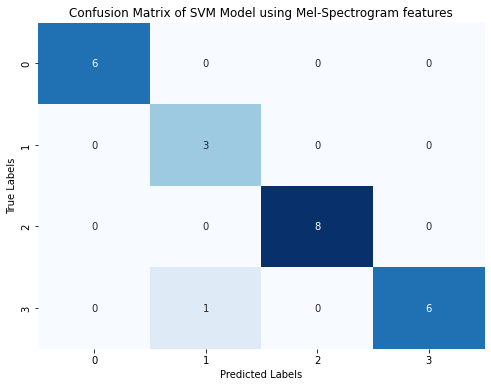

In [9]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Set device
device = "cpu"

# Extract features and labels from the Training DataLoader
x_train, y_train = [], []
for i, data in enumerate(train_dl):
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs         = inputs.view(inputs.size(0), -1).numpy()
    x_train.extend(inputs)
    y_train.extend(labels)

# Extract features and labels from the Testing DataLoader
x_test, y_test = [], []
for i, data in enumerate(test_dl):
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs         = inputs.view(inputs.size(0), -1).numpy()
    x_test.extend(inputs)
    y_test.extend(labels)

# Convert the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

# Initialize an SVM classifier
svm_classifier = svm.SVC(kernel='linear')

# Train the SVM on training set
svm_classifier.fit(x_train, y_train)

# Make predictions on testing set
y_pred = svm_classifier.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("SVM model accuracy: ", accuracy)

plot_confusion_matrix(y_test, y_pred, "SVM Model")

#### Model Training using Random Forest model

Random Forest model accuracy: 0.875


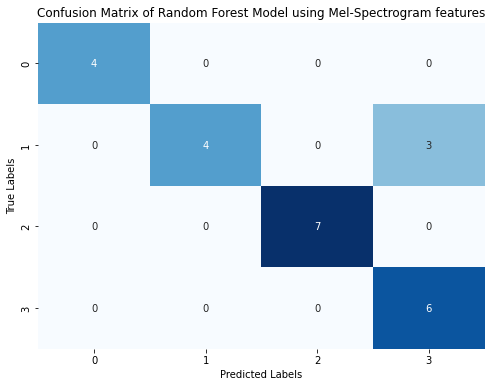

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Set device
device = "cpu"

# Extract features and labels from the Training DataLoader
x_train, y_train = [], []
for i, data in enumerate(train_dl):
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs         = inputs.view(inputs.size(0), -1).numpy()
    x_train.extend(inputs)
    y_train.extend(labels.numpy())

# Extract features and labels from the Testing DataLoader
x_test, y_test = [], []
for i, data in enumerate(test_dl):
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs         = inputs.view(inputs.size(0), -1).numpy()
    x_test.extend(inputs)
    y_test.extend(labels.numpy())

# Convert the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)
    
# Initialize a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest on the training set
random_forest.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = random_forest.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest model accuracy:", accuracy)

plot_confusion_matrix(y_test, y_pred, "Random Forest Model")

#### Model Training using a custom Neural Network

In [9]:
# import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

class CNN_Classifier (nn.Module):
    
    # CNN Model Architecture
    
    def __init__(self):
        super().__init__()
        in_channel     = 2
        num_classes    = 4
        self.channel_1 = 8
        self.channel_2 = 16
        self.channel_3 = 32
        self.channel_4 = 64

        self.block_1  = nn.Sequential(
                        nn.Conv2d(in_channel, self.channel_1, (5,5), padding=2, stride=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(self.channel_1), 
                        )

        self.block_2  = nn.Sequential(
                        nn.Conv2d(self.channel_1, self.channel_2, (3,3), padding=1, stride=2), 
                        nn.ReLU(),
                        nn.BatchNorm2d(self.channel_2),
                        )

        self.block_3  = nn.Sequential(
                        nn.Conv2d(self.channel_2, self.channel_3, (3,3), padding=1, stride=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(self.channel_3),
                        )

        self.block_4  = nn.Sequential(
                        nn.Conv2d(self.channel_3, self.channel_4, (3,3), padding=1, stride=2), 
                        nn.ReLU(),
                        nn.BatchNorm2d(self.channel_4),
                        )


        self.avgpool  = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc       = nn.Linear(self.channel_4, num_classes)
 

    # Forward pass computations
    
    def forward(self, x):
        
        # Run the convolutional blocks
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        # Adaptive Average pool and flatten for input to linear layer
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.fc(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
cnn_Model = CNN_Classifier()
device    = "cpu"
cnn_Model = cnn_Model.to(device)

In [10]:
def training(model, train_dl, num_epochs):
    
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch = int(len(train_dl)), 
                                                  epochs = num_epochs, anneal_strategy = 'linear')

  # Loop as per number of epochs
  for epoch in range(num_epochs):
    running_loss       = 0.0
    correct_prediction = 0
    total_prediction   = 0

    for i, data in enumerate(train_dl):
        
        # Get the input features and target labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward and optimizer steps
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Record loss
        running_loss += loss.item()

        # Predicted class with highest score
        _, prediction = torch.max(outputs, 1)
        
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction   += prediction.shape[0]

    
    # Print progress after each epoch
    num_batches = len(train_dl)
    avg_loss    = running_loss / num_batches
    accuracy    = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}')

  print('Finished Training')
  
num_epochs = 20 
training(cnn_Model, train_dl, num_epochs)

Epoch: 0, Loss: 1.29, Accuracy: 0.51
Epoch: 1, Loss: 1.13, Accuracy: 0.67
Epoch: 2, Loss: 0.94, Accuracy: 0.71
Epoch: 3, Loss: 0.80, Accuracy: 0.79
Epoch: 4, Loss: 0.67, Accuracy: 0.84
Epoch: 5, Loss: 0.55, Accuracy: 0.88
Epoch: 6, Loss: 0.54, Accuracy: 0.88
Epoch: 7, Loss: 0.35, Accuracy: 0.94
Epoch: 8, Loss: 0.33, Accuracy: 0.93
Epoch: 9, Loss: 0.27, Accuracy: 0.96
Epoch: 10, Loss: 0.28, Accuracy: 0.95
Epoch: 11, Loss: 0.30, Accuracy: 0.93
Epoch: 12, Loss: 0.26, Accuracy: 0.95
Epoch: 13, Loss: 0.20, Accuracy: 0.97
Epoch: 14, Loss: 0.21, Accuracy: 0.97
Epoch: 15, Loss: 0.21, Accuracy: 0.96
Epoch: 16, Loss: 0.18, Accuracy: 0.96
Epoch: 17, Loss: 0.21, Accuracy: 0.96
Epoch: 18, Loss: 0.15, Accuracy: 0.98
Epoch: 19, Loss: 0.15, Accuracy: 0.98
Finished Training


CNN Model Test Accuracy: 0.96, Total items: 24


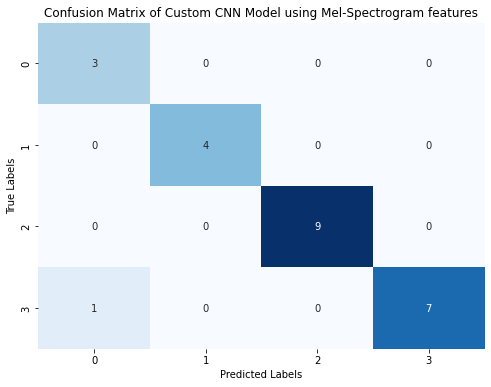

In [13]:
def testing(model, test_dl):
    
    correct_prediction = 0
    total_prediction   = 0
    y_test             = []
    y_pred             = []
    
    with torch.no_grad():
        for data in test_dl:
            
            # Get the input features and target labels
            inputs, labels = data[0].to(device), data[1].to(device)
            y_test.extend(labels.numpy())

            # Get predictions
            outputs = model(inputs)

            # Predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            y_pred.extend(prediction.numpy())

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction   += prediction.shape[0]

    accuracy = correct_prediction/total_prediction
    print(f'CNN Model Test Accuracy: {accuracy:.2f}, Total items: {total_prediction}')
    
    # Convert lists to numpy array
    y_test  = np.array(y_test)
    y_pred  = np.array(y_pred)
    
    plot_confusion_matrix(y_test, y_pred, "Custom CNN Model")

# Testing on trained model with the test set
testing(cnn_Model, test_dl)